In [42]:
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification
from sklearn.utils import resample
from sklearn.metrics import pairwise
from timerun import time_code, time_func
import time
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Pool
from parallel_methods import DSMethods
import pandas as pd
from sklearn import preprocessing

In [43]:
def plot_train_vs_test(train_scores, test_scores, spoint = None, wo = None, points = {}, time = -1, tvar = -1):
    if points != {}: plt.scatter(points.keys(), points.values(), marker='|', zorder = 3)
    plt.plot(train_scores.keys(), train_scores.values(), label = "Train", zorder = 2)
    plt.plot(test_scores.keys(), test_scores.values(), label = "Test", zorder = 1)
    
    xleft, xright = plt.xlim()
    if spoint and wo:
        plt.scatter(spoint[0], spoint[1], s=10, c='red')
        w = [-wo[1]/n_features, wo[0]]
        b = w[0]*spoint[0] + w[1]*spoint[1]
        xleft, xright = plt.xlim()
        xd = np.array([xleft, xright])
        yd = [(b - w[0]*xd[0]) / w[1], (b - w[0]*xd[1]) / w[1]]
        plt.plot(xd, yd, lw=1, c='red')
    
    plt.legend()
    plt.ylim([0.4,1.0])
    plt.xlim([xleft, xright])
    plt.axhline(0.5, color = "red", linewidth=1, linestyle="--")

    plt.show()

    print("AT", spoint, "WITH", len(points), "ITERATIONS IN", time, "SECONDS :", tvar)

def scal(data, w):
    obj = np.array([w[0] * (1 - acc) + w[1] * (i / n_features) for i, acc in data.items()])
    spoint_x = list(data.keys())[np.argmin(obj)]
    spoint_y = data[spoint_x]
    return (spoint_x, spoint_y, obj[np.argmin(obj)])

def mean_of_arrays(data):
    arr = {}
    for x in data[0]:
        arr[x] = np.mean([data[v][x] for v in data])
    return arr

In [44]:
n_features = 500

# Load the madelon training dataset
train_data = pd.read_table("MADELON/madelon_train.data", sep=' ', header=None, usecols=range(0,500))
train_labels = pd.read_table("MADELON/madelon_train.labels", sep=' ', header=None)
X_train, X_test = np.split(preprocessing.scale(train_data.to_numpy()), [400])
y_train, y_test = np.split(np.ravel(train_labels.to_numpy()), [400])

data = DSMethods(n_features, X_train, y_train, X_test, y_test)

# Lineal vs. Non-Lineal

In [45]:
@time_func
def RANDOM_SELECTION(CVal = 0.1, kernel='liblinear'):
    data.kernel = kernel
    with Pool(6) as pool:
        scores = pool.map(data.randomSelection, [CVal]*10)
    
    #scores = list(map(data.randomSelection, [0.1]))

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    time         = np.mean([x[2] for x in scores])
    plot_train_vs_test(train_scores, test_scores)

In [46]:
#RANDOM_SELECTION()
#RANDOM_SELECTION(kernel='linear')

#data.kernel_matrix = 'poly'
#RANDOM_SELECTION(kernel='precomputed')

#data.kernel_matrix = None
#RANDOM_SELECTION(kernel='poly')

# SVM

In [47]:
@time_func
def SVM_RFE_W_STEP(step, C = 0.5, gamma = 3, kernel = 'linear', w1 = [0.8, 0.2]):
    data.kernel = 'precomputed'
    data.kernel_matrix = kernel
    data.C = C
    data.gamma = gamma
    kf = KFold(n_splits=6, shuffle=True)

    index = [(train_index, test_index, step) for train_index, test_index in kf.split(data.X_train)]
    with Pool(7) as pool:
        scores = pool.map(data.svm_rfe_kernel, index)

    #scores = list(map(data.svm_rfe_kernel, index))
    scores = list(scores)

    train_scores = mean_of_arrays({i: x[0] for i, x in enumerate(scores)})
    test_scores  = mean_of_arrays({i: x[1] for i, x in enumerate(scores)})
    points       = mean_of_arrays({i: x[2] for i, x in enumerate(scores)})
    time         = np.mean([x[3] for x in scores])
    tvar         = np.var([x[3] for x in scores])

    print(kernel, C, gamma)
    plot_train_vs_test(train_scores, test_scores, scal(test_scores, w1), w1, points, time, tvar)
    

rbf 0.3 0.01


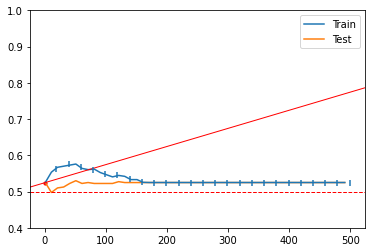

AT (1, 0.5248379315543495, 0.3805296547565204) WITH 25 ITERATIONS IN 47.809632341066994 SECONDS : 0.7760890262259261
__main__.SVM_RFE_W_STEP - 00:00:51.207911700
rbf 0.3 0.015


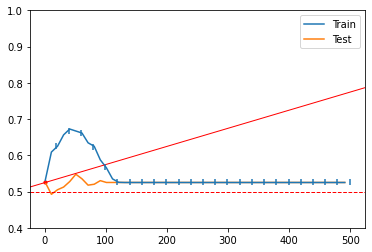

AT (1, 0.525101763907734, 0.3803185888738128) WITH 25 ITERATIONS IN 52.46380281448364 SECONDS : 6.007682387559498
__main__.SVM_RFE_W_STEP - 00:00:56.661690900
rbf 0.3 0.02


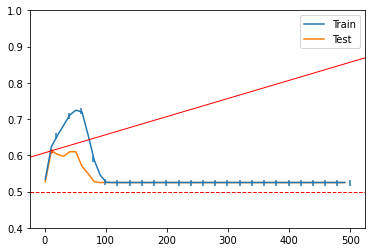

AT (11, 0.6123925825418363, 0.314485933966531) WITH 25 ITERATIONS IN 48.66085469722748 SECONDS : 0.0987645614838802
__main__.SVM_RFE_W_STEP - 00:00:51.552031500
rbf 0.3 0.025


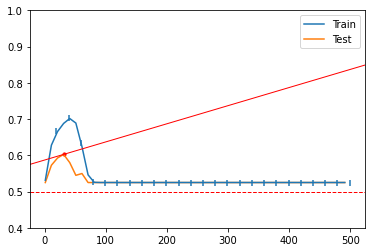

AT (31, 0.6025554047942107, 0.3303556761646315) WITH 25 ITERATIONS IN 48.63225920995077 SECONDS : 0.14972355480846825
__main__.SVM_RFE_W_STEP - 00:00:51.408225900
rbf 0.3 0.03


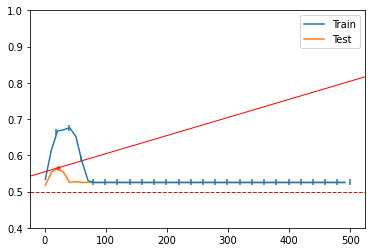

AT (21, 0.565015829941203, 0.3563873360470376) WITH 25 ITERATIONS IN 48.30687749385834 SECONDS : 2.944740521558567
__main__.SVM_RFE_W_STEP - 00:00:52.250417100
rbf 0.3 0.035


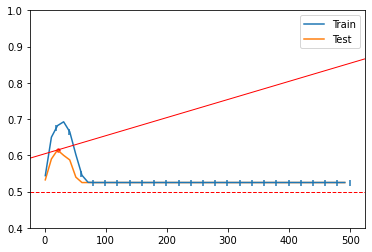

AT (21, 0.614691693049902, 0.31664664556007843) WITH 25 ITERATIONS IN 49.374088962872825 SECONDS : 2.0343242707011657
__main__.SVM_RFE_W_STEP - 00:00:53.412185000
rbf 0.3 0.04


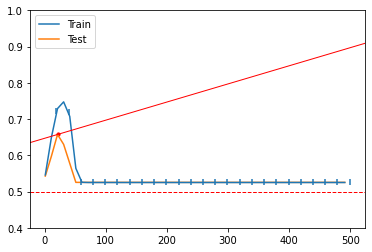

AT (21, 0.6575456053067993, 0.2823635157545606) WITH 25 ITERATIONS IN 48.868271589279175 SECONDS : 1.4934035552488087
__main__.SVM_RFE_W_STEP - 00:00:52.368265400
rbf 0.3 0.045


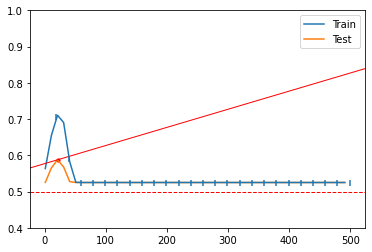

AT (21, 0.5876300316598823, 0.3382959746720942) WITH 25 ITERATIONS IN 48.44601833820343 SECONDS : 0.1276882056501023
__main__.SVM_RFE_W_STEP - 00:00:51.340000200
rbf 0.3 0.05


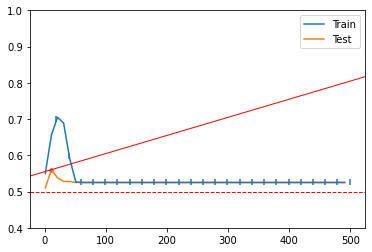

AT (11, 0.5603422282526761, 0.35612621739785916) WITH 25 ITERATIONS IN 49.5361123085022 SECONDS : 0.10051551766910431
__main__.SVM_RFE_W_STEP - 00:00:52.284021100
rbf 0.3 0.055


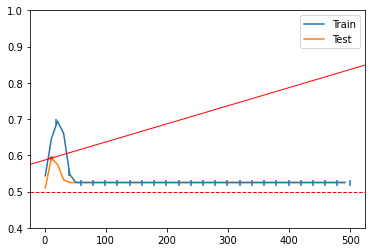

AT (11, 0.5923790140208051, 0.330496788783356) WITH 25 ITERATIONS IN 48.87887911001841 SECONDS : 2.4324078022302427
__main__.SVM_RFE_W_STEP - 00:00:52.752503100


In [48]:
SVM_RFE_W_STEP(20, 0.3, 0.010, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.015, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.025, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.035, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.040, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.045, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.050, 'rbf')
SVM_RFE_W_STEP(20, 0.3, 0.055, 'rbf')


rbf 0.4 0.02


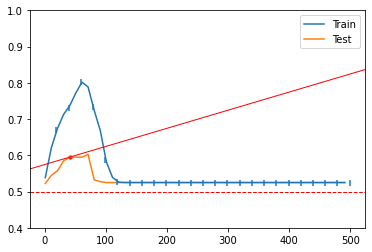

AT (41, 0.5950173375546509, 0.3403861299562793) WITH 25 ITERATIONS IN 46.38838505744934 SECONDS : 0.28984140001546166
__main__.SVM_RFE_W_STEP - 00:00:49.439808200
rbf 0.4 0.025


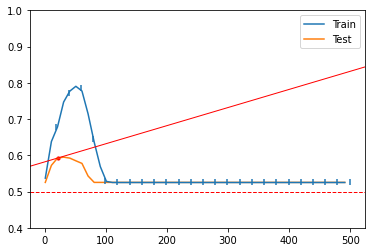

AT (21, 0.5923790140208051, 0.334496788783356) WITH 25 ITERATIONS IN 46.85373520851135 SECONDS : 0.8749796007492895
__main__.SVM_RFE_W_STEP - 00:00:50.056788700
rbf 0.4 0.03


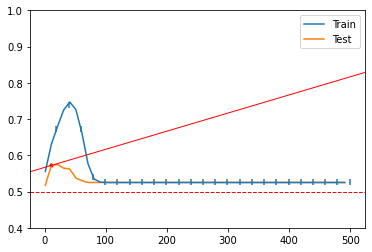

AT (11, 0.572176993818785, 0.3466584049449721) WITH 25 ITERATIONS IN 46.3543594678243 SECONDS : 0.12516762912451265
__main__.SVM_RFE_W_STEP - 00:00:49.125059700
rbf 0.4 0.035


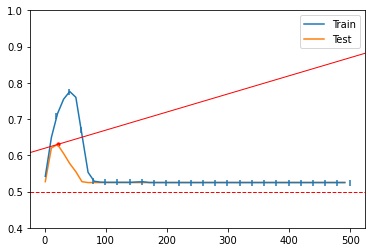

AT (21, 0.6299939695462083, 0.30440482436303334) WITH 25 ITERATIONS IN 47.27550498644511 SECONDS : 0.1583623580801196
__main__.SVM_RFE_W_STEP - 00:00:50.228129600
rbf 0.4 0.04


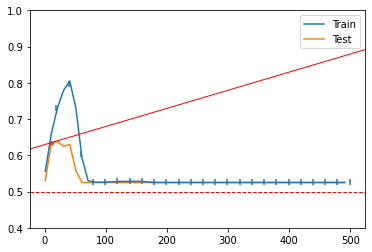

AT (11, 0.6350821649329111, 0.29633426805367113) WITH 25 ITERATIONS IN 46.68579419453939 SECONDS : 0.021229743029013867
__main__.SVM_RFE_W_STEP - 00:00:49.362122700


In [49]:
SVM_RFE_W_STEP(20, 0.4, 0.020, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.025, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.030, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.035, 'rbf')
SVM_RFE_W_STEP(20, 0.4, 0.040, 'rbf')

rbf 0.5 0.02


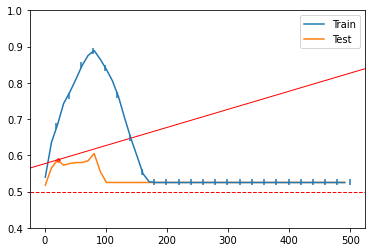

AT (21, 0.5874038896426955, 0.3384768882858436) WITH 25 ITERATIONS IN 47.33873780568441 SECONDS : 2.2007185300114367
__main__.SVM_RFE_W_STEP - 00:00:51.106366900
rbf 0.5 0.03


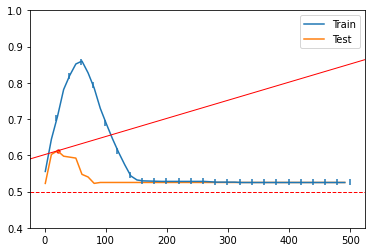

AT (21, 0.6124679632142319, 0.3184256294286145) WITH 25 ITERATIONS IN 49.504303415616356 SECONDS : 0.3756384714686081
__main__.SVM_RFE_W_STEP - 00:00:53.040079600
rbf 0.5 0.04


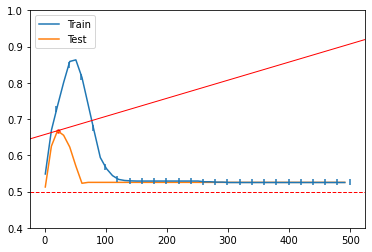

AT (21, 0.6678727574249962, 0.27410179406000307) WITH 25 ITERATIONS IN 50.341100533803306 SECONDS : 1.5648431995864234
__main__.SVM_RFE_W_STEP - 00:00:53.978455400
rbf 0.5 0.05


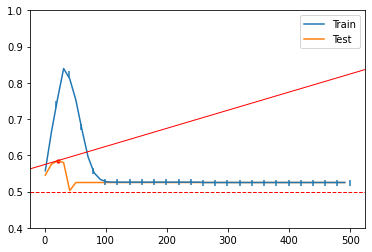

AT (21, 0.5850670887984321, 0.3403463289612544) WITH 25 ITERATIONS IN 49.555148005485535 SECONDS : 0.15190688245526474
__main__.SVM_RFE_W_STEP - 00:00:52.601866800
rbf 0.5 0.06


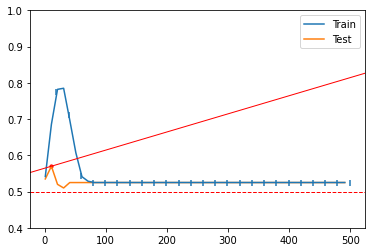

AT (11, 0.5699532639831147, 0.3484373888135082) WITH 25 ITERATIONS IN 50.497575322786965 SECONDS : 3.2301371006418815
__main__.SVM_RFE_W_STEP - 00:00:54.533876900


In [50]:
SVM_RFE_W_STEP(20, 0.5, 0.02, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.03, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.04, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.05, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.06, 'rbf')

rbf 0.5 0.005


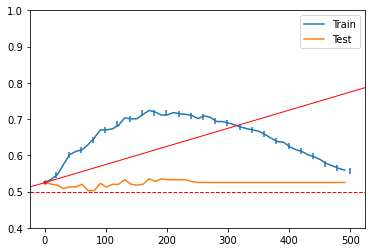

AT (1, 0.5251394542439318, 0.38028843660485456) WITH 25 ITERATIONS IN 49.16860063870748 SECONDS : 0.27361356432396
__main__.SVM_RFE_W_STEP - 00:00:52.301140300
rbf 0.5 0.01


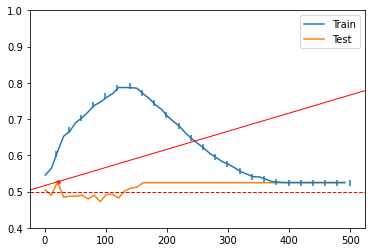

AT (21, 0.5269862807176241, 0.38681097542590076) WITH 25 ITERATIONS IN 50.348907828330994 SECONDS : 0.28853878560601726
__main__.SVM_RFE_W_STEP - 00:00:53.372288300
rbf 0.5 0.015


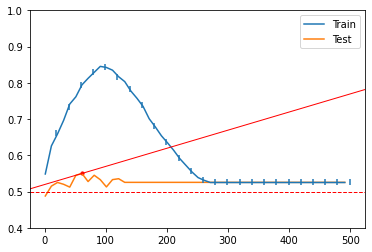

AT (61, 0.5499773857982814, 0.3844180913613749) WITH 25 ITERATIONS IN 51.47232321898142 SECONDS : 4.529207756851243
__main__.SVM_RFE_W_STEP - 00:00:55.761034700


In [51]:
SVM_RFE_W_STEP(20, 0.5, 0.005, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.010, 'rbf')
SVM_RFE_W_STEP(20, 0.5, 0.015, 'rbf')